<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-Hyperparameters" data-toc-modified-id="Set-Hyperparameters-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set Hyperparameters</a></span></li><li><span><a href="#Prepare-the-MNIST-Dataset" data-toc-modified-id="Prepare-the-MNIST-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare the MNIST Dataset</a></span></li><li><span><a href="#Create-a-Neural-Network" data-toc-modified-id="Create-a-Neural-Network-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Create a Neural Network</a></span></li><li><span><a href="#Train-Classifier" data-toc-modified-id="Train-Classifier-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train Classifier</a></span></li></ul></div>

# Mini-Batch Stochastic Gradient Descent

In this notebook we will:

1. set initial hyperparameters,
2. prepare the MNIST dataset,
3. create a simple, fully connected neural network, and then
4. train a neural network to classify digits.

## Set Hyperparameters

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchsummary import summary

from torchvision.datasets import MNIST
from torchvision.transforms import Compose, Normalize, ToTensor

from fastprogress.fastprogress import master_bar, progress_bar

import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context="talk")

In [2]:
# Let's use some shared space for the data (so that we don't have copies
# sitting around everywhere)
data_path = "/raid/cs152/cache/pytorch/data"

# Use the GPUs if they are available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using '{device}' device.")

# Model hyperparameters
neurons_per_layer = [13, 17]

# Mini-Batch SGD hyperparameters
batch_size = 256
num_epochs = 10
learning_rate = 0.01

criterion = nn.CrossEntropyLoss()

Using 'cuda' device.


## Prepare the MNIST Dataset

In [3]:
def get_mnist_data_loaders(path, batch_size, valid_batch_size=0):

    # MNIST specific transforms
    mnist_mean = (0.1307,)
    mnist_std = (0.3081,)
    mnist_xforms = Compose([ToTensor(), Normalize(mnist_mean, mnist_std)])

    # Training data loader
    train_dataset = MNIST(root=path, train=True, download=True, transform=mnist_xforms)

    # Set the batch size to N if batch_size is 0
    tbs = len(train_dataset) if batch_size == 0 else batch_size
    train_loader = DataLoader(train_dataset, batch_size=tbs, shuffle=True)

    # Validation data loader
    valid_dataset = MNIST(root=path, train=False, download=True, transform=mnist_xforms)

    # Set the batch size to N if batch_size is 0
    vbs = len(valid_dataset) if valid_batch_size == 0 else valid_batch_size
    valid_loader = DataLoader(valid_dataset, batch_size=vbs, shuffle=True)

    return train_loader, valid_loader

In [4]:
train_loader, valid_loader = get_mnist_data_loaders(data_path, batch_size)

print("Training dataset shape   :", train_loader.dataset.data.shape)
print("Validation dataset shape :", valid_loader.dataset.data.shape)

# Notice that each example is 28x28. These are images

Training dataset shape   : torch.Size([60000, 28, 28])
Validation dataset shape : torch.Size([10000, 28, 28])


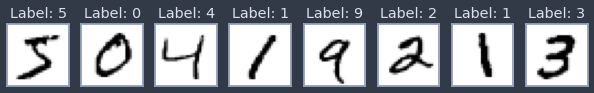

In [5]:
# Let's plot a few images as an example
num_to_show = 8
images = train_loader.dataset.data[:num_to_show]
labels = train_loader.dataset.targets[:num_to_show]

fig, axes = plt.subplots(1, num_to_show)

for axis, image, label in zip(axes, images, labels):
    axis.imshow(image.squeeze(), cmap="Greys")
    axis.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_title(f"Label: {label}")

## Create a Neural Network

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes):
        super(NeuralNetwork, self).__init__()

        # The first "layer" just rearranges the Nx28x28 input into Nx784
        first_layer = nn.Flatten()

        # The hidden layers include:
        # 1. a linear component (Z) and
        # 2. a non-linear component (A)
        hidden_layers = [
            nn.Sequential(nn.Linear(nlminus1, nl), nn.ReLU())
            for nl, nlminus1 in zip(layer_sizes[1:-1], layer_sizes)
        ]

        # The output layer does not include an activation function.
        # See: https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        output_layer = nn.Linear(layer_sizes[-2], layer_sizes[-1])

        # Group all layers into the sequential container
        all_layers = [first_layer] + hidden_layers + [output_layer]
        self.layers = nn.Sequential(*all_layers)

    def forward(self, X):
        return self.layers(X)

In [7]:
# The input layer size depends on the dataset
n0 = train_loader.dataset.data.shape[1:].numel()

# The output layer size depends on the dataset
nL = len(train_loader.dataset.classes)

# Preprend the input and append the output layer sizes
layer_sizes = [n0] + neurons_per_layer + [nL]
model = NeuralNetwork(layer_sizes).to(device)

summary(model);

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Flatten: 2-1                      --
|    └─Sequential: 2-2                   --
|    |    └─Linear: 3-1                  10,205
|    |    └─ReLU: 3-2                    --
|    └─Sequential: 2-3                   --
|    |    └─Linear: 3-3                  238
|    |    └─ReLU: 3-4                    --
|    └─Linear: 2-4                       180
Total params: 10,623
Trainable params: 10,623
Non-trainable params: 0


## Train Classifier

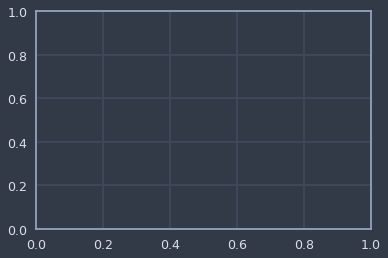

In [8]:
# A master bar for fancy output progress
mb = master_bar(range(num_epochs))

# Information for plots
mb.names = ["Train Loss", "Valid Loss"]
train_losses = []
valid_losses = []

for epoch in mb:

    #
    # Training
    #
    model.train()

    train_N = len(train_loader.dataset)
    num_train_batches = len(train_loader)
    train_dataiterator = iter(train_loader)

    train_loss_mean = 0

    for batch in progress_bar(range(num_train_batches), parent=mb):

        # Grab the batch of data and send it to the correct device
        X, Y = next(train_dataiterator)
        X, Y = X.to(device), Y.to(device)

        # Compute the output
        train_output = model(X)

        # Compute loss
        train_loss = criterion(train_output, Y)

        num_in_batch = len(X)
        tloss = train_loss.item() * num_in_batch / train_N
        train_loss_mean += tloss
        train_losses.append(train_loss.item())

        # Compute partial derivatives
        model.zero_grad()
        train_loss.backward()

        # Update parameters
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad

    #
    # Validation
    #
    model.eval()

    valid_N = len(valid_loader.dataset)
    num_valid_batches = len(valid_loader)

    valid_loss_mean = 0
    valid_correct = 0

    with torch.no_grad():

        # valid_loader is probably just one large batch, so not using progress bar
        for X, Y in valid_loader:

            X, Y = X.to(device), Y.to(device)

            valid_output = model(X)

            valid_loss = criterion(valid_output, Y)

            num_in_batch = len(X)
            vloss = valid_loss.item() * num_in_batch / valid_N
            valid_loss_mean += vloss
            valid_losses.append(valid_loss.item())

            # Convert network output into predictions (one-hot -> number)
            predictions = valid_output.argmax(1)

            # Sum up total number that were correct
            valid_correct += (predictions == Y).type(torch.float).sum().item()

    valid_accuracy = 100 * (valid_correct / valid_N)

    # Report information
    tloss = f"Train Loss = {train_loss_mean:.4f}"
    vloss = f"Valid Loss = {valid_loss_mean:.4f}"
    vaccu = f"Valid Accuracy = {(valid_accuracy):>0.1f}%"
    mb.write(f"[{epoch+1:>2}/{num_epochs}] {tloss}; {vloss}; {vaccu}")

    # Update plot data
    max_loss = max(max(train_losses), max(valid_losses))
    min_loss = min(min(train_losses), min(valid_losses))
    
    x_margin = 0.2
    x_bounds = [0 - x_margin, num_epochs + x_margin]

    y_margin = 0.1
    y_bounds = [min_loss - y_margin, max_loss + y_margin]

    train_xaxis = torch.linspace(0, epoch + 1, len(train_losses))
    valid_xaxis = torch.linspace(1, epoch + 1, len(valid_losses))
    graph_data = [[train_xaxis, train_losses], [valid_xaxis, valid_losses]]

    mb.update_graph(graph_data, x_bounds, y_bounds)

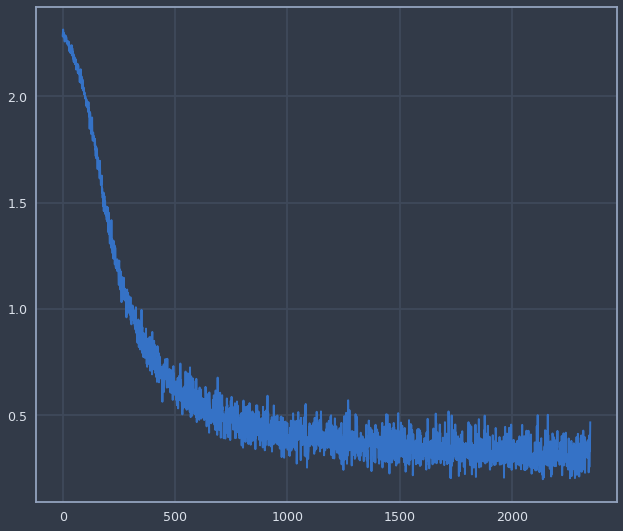

In [9]:
plt.plot(train_losses)